## 1. 获取数据并创建环境

In [47]:
import numpy as np
import pandas as pd

In [48]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [49]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


可以看到，上面test数据缺最终销售价格的一列。

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


下面是在数据描述文件中的一些字段:

- SalesPrice——以美元计算的房地产的售价。这是你要预测的目标变量。
- MSSubClass——房地产建筑类别
- MSZoning ——一般的地区区分类
- LotFrontage——与房地产相距的街道英尺距离（？）
- LotArea -用平方英尺表示的大小
- Stret——所在道路的类型
- Alley-所在巷通道的类型
- LotShape -----房地产形状的分类
- LandContour-----土地的平整性
- Utilities-----可用的实用工具类型
- LotConfig——大小配置

比赛要求你预测每个家庭的最终价格。在这一点上，我们应该开始考虑我们对艾姆斯、爱荷华州(Ames, Iowa,)住房价格的了解，以及我们在这个数据集中可能看到的东西。

从这些数据，我们看到了我们所期望的特性，YrSold(房子的最后出售时间)和SalePrice。还有一些我们可能没有预料到的，比如，LandSlope(建造在屋顶上的房屋的坡度), RoofMatl(用来建造屋顶的材料)。稍后，我们将不得不决定如何处理这些字段和其他特性字段。

可以在项目的探索阶段进行一些可视化预览工作，也需要将这些功能导入到我们的环境中。预览允许我们可视化数据的分布，检查离群值，查看可能忽略的其他模式。我们将使用一个流行的可视化库Matplotlib来做这件事。

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. 数据挖掘 & 特征工程

In [9]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skew is: 1.88287575977


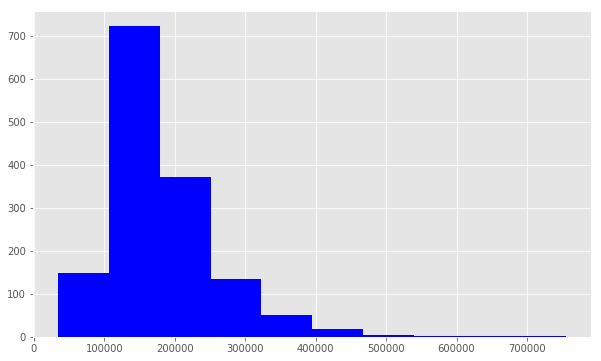

In [10]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

Skew is: 0.121335062205


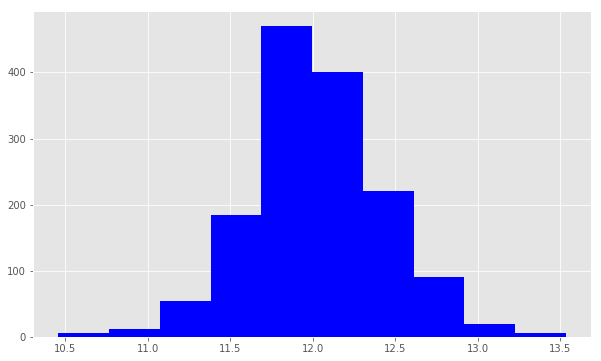

In [11]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [12]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [13]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [14]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [15]:
quality_pivot = train.pivot_table(index='OverallQual',
                                  values='SalePrice', aggfunc=np.median)
quality_pivot

OverallQual
1      50150
2      60000
3      86250
4     108000
5     133000
6     160000
7     200141
8     269750
9     345000
10    432390
Name: SalePrice, dtype: int64

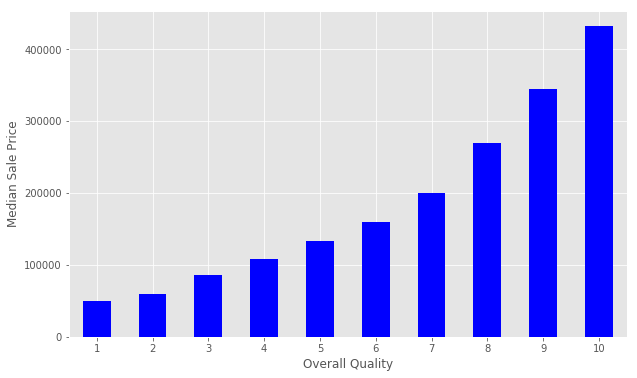

In [16]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

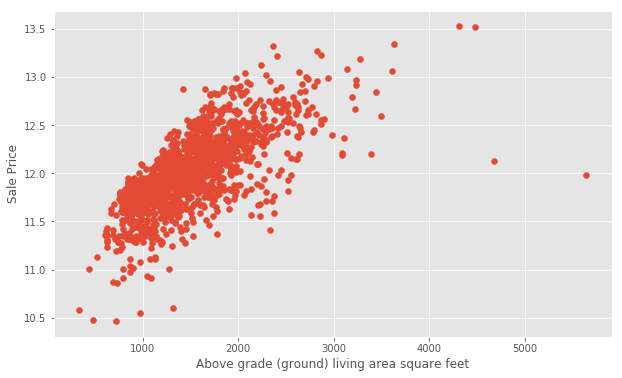

In [17]:
plt.scatter(x=train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

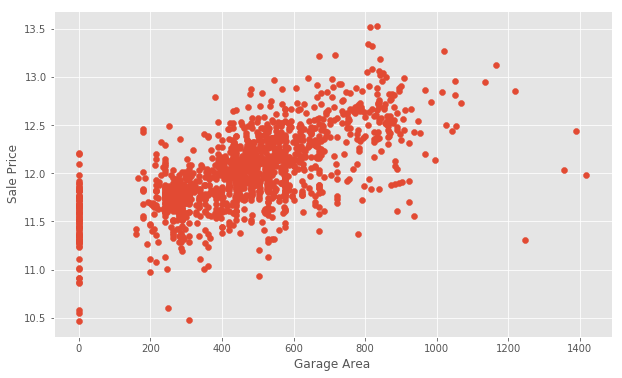

In [18]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [19]:
train = train[train['GarageArea'] < 1200]

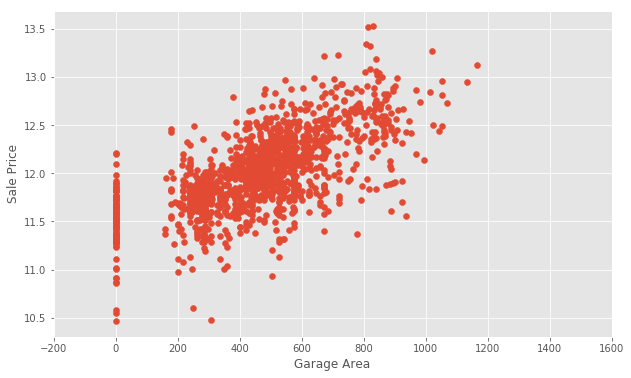

In [20]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [21]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


In [22]:
print ("Unique values are:", train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [23]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Fa,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


In [24]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



In [25]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [26]:
print ('Encoded: \n') 
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


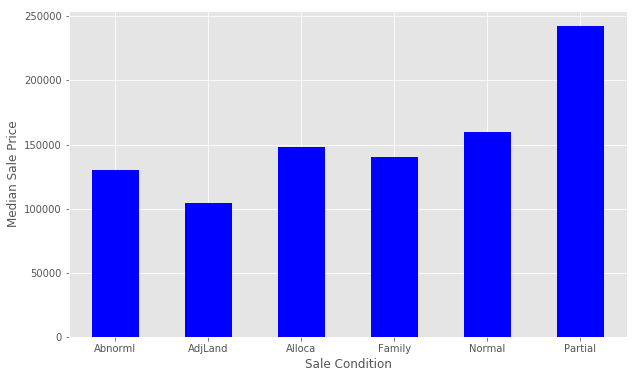

In [27]:
condition_pivot = train.pivot_table(index='SaleCondition',
                                    values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [28]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

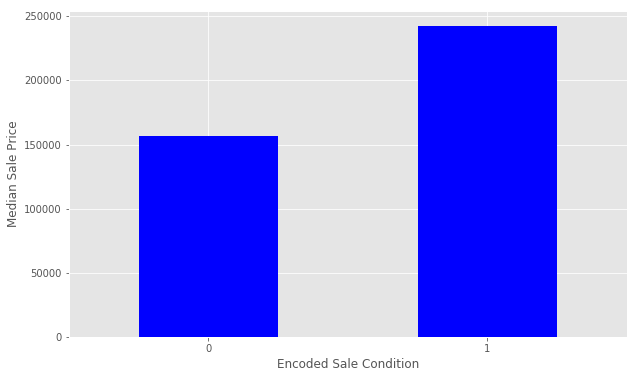

In [29]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [30]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna() 

In [31]:
sum(data.isnull().sum() != 0)

0

## 3. 构建线性模型

In [32]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.33)

In [34]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [35]:
model = lr.fit(X_train, y_train)

/Users/Herb/Library/Python/3.5/lib/python/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [36]:
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.888247770926


In [37]:
predictions = model.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.0178417945196


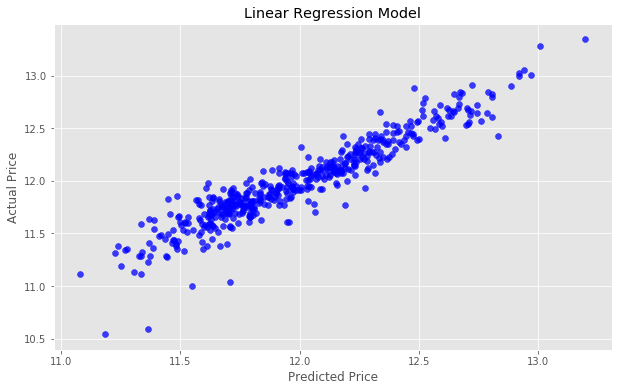

In [39]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

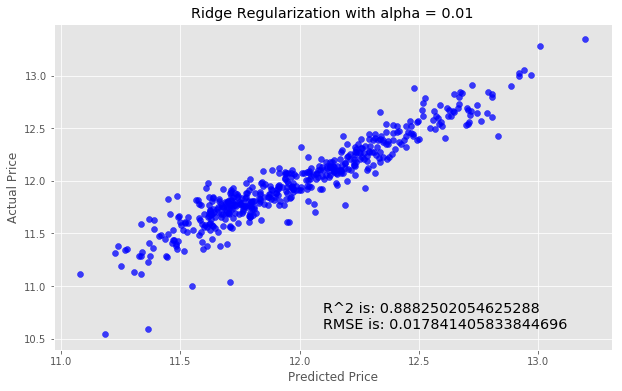

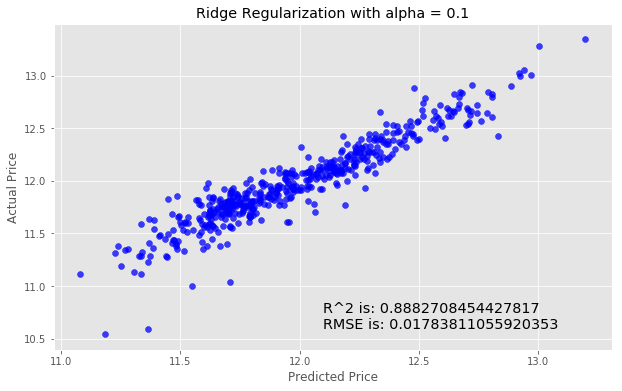

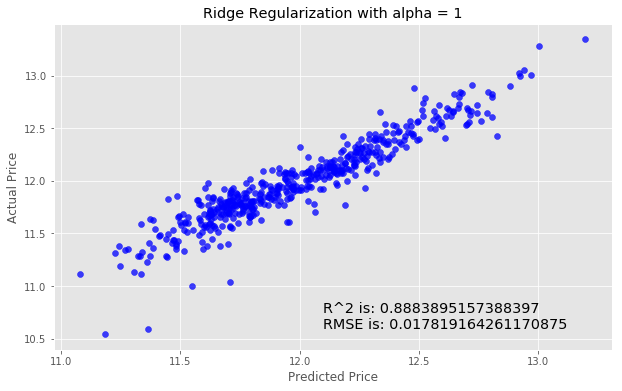

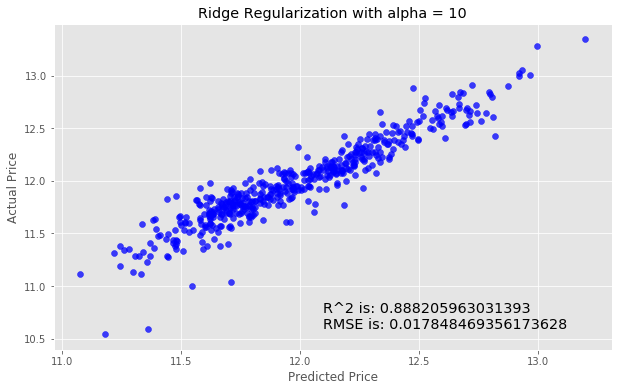

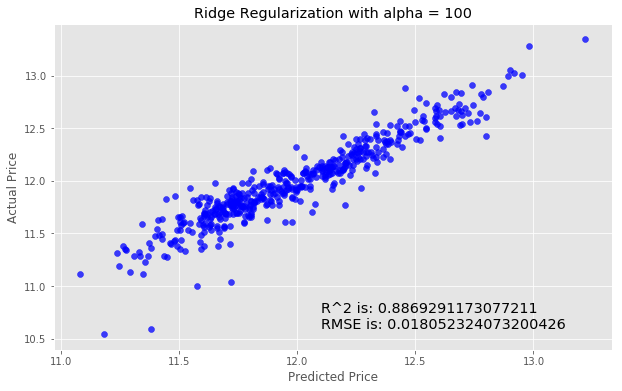

In [40]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

In [41]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [42]:
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

In [43]:
predictions = model.predict(feats)

In [44]:
final_predictions = np.exp(predictions)

In [45]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [ 11.76725362  11.71929504  12.07656074  12.20632678  12.11217655] 

Final predictions are: 
 [ 128959.49172586  122920.74024358  175704.82598102  200050.83263756
  182075.46986405]


In [46]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,128959.491726
1,1462,122920.740244
2,1463,175704.825981
3,1464,200050.832638
4,1465,182075.469864


In [ ]:
#submission.to_csv('submission1.csv', index=False)